_Daily Weather Observations_
---

In [1]:
# imports and global conf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={"figure.dpi":72, 'savefig.dpi':200})
sns.set_theme(font_scale=1.25)

# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('retina')

In [2]:
# Read dataset (df) & merge regions (Group, Region)
df = pd.read_csv('datasets/weatherAUS.csv', parse_dates=['Date'])
st = pd.read_csv('datasets/locations-regions.csv')
df = df.merge(st[['Location', 'Region', 'Group']], on='Location')
del st

In [3]:
# Geodata load & pre-processing (aprox. ~35 sec)

import geopandas as gpd
from shapely.geometry import Point

# CRS : Coordinate Refernce System
# GPS               EPSG:4326
# Shapefile         EPSG:4283
# Web Mercator      EPSG:3857
# 'flat'            3035

# Australia shapes
ozshape = gpd.read_file("datasets/geo/STE_2021_AUST_SHP_GDA94/STE_2021_AUST_GDA94.shp")
ozshape.to_crs(epsg=4326, inplace=True)

# Regions names ?
# regions = ozshape[ozshape.geometry.notnull()].copy()
# regions['geometry'] = regions.geometry.to_crs(epsg=3035).centroid.to_crs(epsg=4326)

# Locations
locations = gpd.read_file('datasets/locations-regions.csv')
locations['geometry'] = gpd.GeoSeries([Point((l.Lon, l.Lat)) for i, l in locations.iterrows()], crs=4326)

# Weather stations
# Can't fill Na and filter data directly in GeoPandas df, we must do it from a pandas df
stations = pd.read_csv('datasets/weather-stations.csv')
stations.fillna({"End": 2023}, inplace=True)
stations = stations[stations['End'] > 2007][['Site name', 'Lat', 'Lon']].reset_index()
stations = gpd.GeoDataFrame(stations)
stations['geometry'] = gpd.GeoSeries([Point((l.Lon, l.Lat)) for i, l in stations.iterrows()], crs=4326)
stations = stations.sjoin(ozshape)

# Climate
climate = gpd.read_file('datasets/geo/other_climate_2007_koppen_geiger/other_climate_2007_koppen_geiger.shp')
climate.to_crs(epsg=4326, inplace=True)
climate = climate.sjoin(ozshape).drop_duplicates(subset='identity')
tmp = pd.read_csv("datasets/koppen-table.csv", sep=";")
climate = climate.assign(KCode=climate.climate.str.split(" ").str[0])
climate = climate.merge(tmp, on='KCode')
del(tmp)

def climateMerged(df):
    """Returns df labeled with climate (adds 'Climate' and 'Color' vars).
    df shoud be the main dataset
    """
    # Joins location's and climate's geometries, so we can label each observation with a climate
    clim = climate[['geometry', 'EN', 'Color']].rename({'EN':'Climate'}, axis=1).to_crs(epsg=3035)
    clim = locations.to_crs(epsg=3035).sjoin_nearest(clim).to_crs(epsg=4326)
    return df.merge(clim[['Location', 'Climate', 'Color']], on='Location')

## Introduction

La prévision météorologique est réalisée à l'aide de modèles mathématiques qui simulent l'évolution de l'atmosphère en utilisant les lois physiques. Les modèles sont alimentés par des données d'observation provenant de stations météorologiques, satellites, etc. et prennent en compte les variables telles que la pression atmosphérique, la température, l'humidité, la vitesse et les directions des vents pour produire des prévisions à court, moyen et long terme.

Les prévisions sont généralement fournies sous forme de carte météorologique, qui montre les prévisions de température, de précipitations, de vent, etc. sur une zone géographique donnée. Les prévisions de pluie sont généralement exprimées en termes de probabilité de précipitations sur une période donnée, par exemple, la probabilité de précipitations supérieures à 1 mm sur une période de 24 heures.

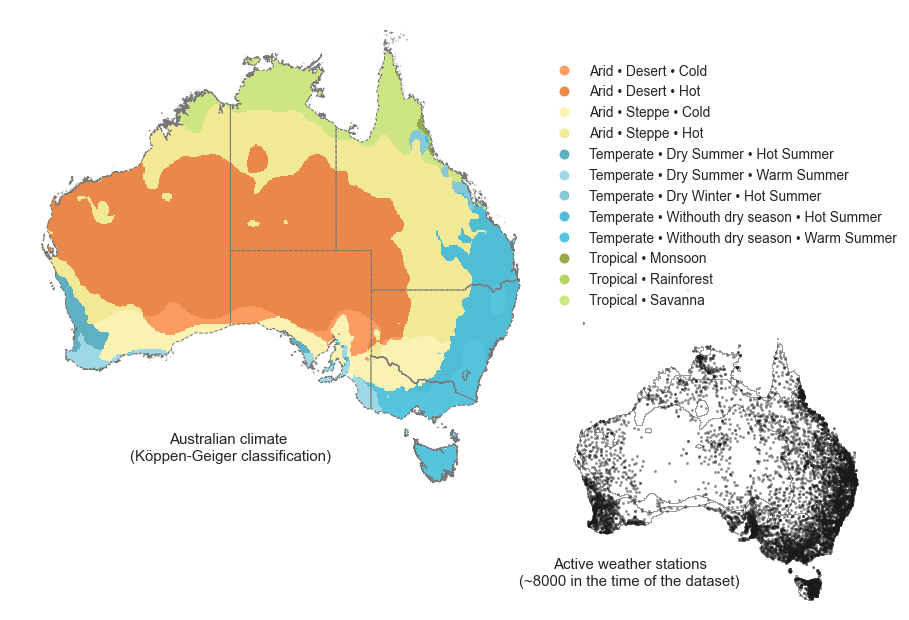

In [4]:
# Climate zones & weather stations density

# Build matplot legend
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html#sphx-glr-gallery-text-labels-and-annotations-custom-legends-py
# https://stackoverflow.com/questions/32012120/matplotlib-legend-vertical-rotation

# Color maps memo
# PuOr BuPu viridis inferno plasma magma tab20b OrRd

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(16,10))
ax.set_facecolor('white')
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(110, 186)

# Plot climate zones sorted to match color map
sorted = climate.sort_values('EN')
sorted.plot(ax=ax, column='EN', cmap=ListedColormap(sorted.Color.unique()),
            linewidth=0, legend=True, 
            legend_kwds={"facecolor":"white", "edgecolor":"w"})
ax.legend_.set_bbox_to_anchor((1.01,.91))

# Plot regions ?
ozshape.plot("STE_NAME21", ax=ax, linewidth=1, edgecolor='#777', facecolor='none', linestyle="dashed")
plt.title("Australian climate \n(Köppen-Geiger classification)", x=.25, y=.08, fontsize=15)

# Weather stations densities
ax = plt.axes([.5,0.,.5,.4])
ax.set_facecolor('white')
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(110, 160)

climate.plot("climate", ax=ax, facecolor="none", edgecolor="#999", legend=False)
sorted = stations[['Site name', 'geometry']].sjoin(climate[['EN', 'Color', 'geometry']])
sorted.plot(ax=ax, linewidth=0, markersize=8, color='k', alpha=.5, legend=False)
plt.title("Active weather stations\n(~8000 in the time of the dataset)", x=.22, y=.075, fontsize=15)

del(fig, ax, sorted)
plt.savefig("outpout/australian-climate & stations-density.png")

### Objectif du projet

_De l'importance de la prévision de la pluie en Australie_

L'Australie est un pays avec des zones arides et semi-arides importantes, les incendies de forêts y sont fréquents, surtout pendant les périodes de sécheresse. La pluie est vitale pour la survie de la faune et de la flore et essentielle pour l'agriculture, l'un des piliers économiques de l'Australie.

Bien que les précipitations soient souvent faibles, tout au long de son histoire l'Australie à subit des inondations aux conséquences dévastatrices. La prévision de la pluie peut permettre de prendre des mesures pour minimiser les dommages causés par les inondations.

En somme, la prévision de la pluie en Australie est cruciale pour la sécurité et le bien-être des êtres humains, de la faune et de l'économie.

_Contribuer à améliorer la précision des prévisions en Australie_

Les modèles numériques de prévision du temps peuvent être limités par des facteurs tels que la qualité des données d'observation, la résolution spatiale et temporelle du modèle, l'incertitude des équations mathématiques et des paramètres physiques utilisés dans le modèle. Par conséquent, l'utilisation de méthodes de machine learning peut aider à améliorer la précision des prévisions météorologiques en utilisant des techniques de traitement des données et de modélisation plus avancées pour extraire des relations et des modèles à partir des données d'observation.

### Présentation du jeu de données

Le jeu de données Rain in Australia étudié dans ce rapport provient de Kaggle (disponible à cette adresse https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package).

Ce jeu rassemble 10 années d'observations quotidiennes provenant de ~8000 stations météorologiques réparties sur le territoire australien pour la période du 01/11/2007 au 25/06/2017. Des données supplémentaires (observations, statistiques...) sont accessibles aux services de données du Bureau Météorologique Gouvernemental Australien http://www.bom.gov.au/climate/data-services

Il est à noter que certaines observations sont le résultat d'une accumulation d'observations passées (ie. une station n'a pu effectuer ses relevés).

http://www.bom.gov.au/climate/cdo/about/about-rain-data.shtml
https://koordinates.com/layer/740-australian-vegetation-pre-european-settlement-1788/`

Dénombrement des observations sur toute la période couverte par le dataset (2007-12 2017-12)

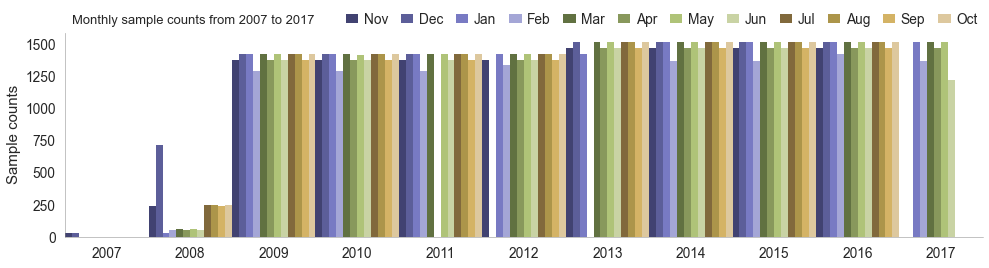

In [7]:
# Monthly sample counts (whole dataset)

# Group by and extract year/month
tmp = df.groupby(df.Date.dt.to_period('M'), as_index=False).size()
tmp = tmp.assign(Month=tmp.Date.dt.strftime("%b"), Year=tmp.Date.dt.year)

# Plot ! PuOr BuPu viridis inferno plasma magma tab20b OrRd
fig = plt.figure(figsize=(14, 4))
ax = sns.barplot(tmp, x='Year', y='size', hue='Month', palette="tab20b",
                errorbar=None, linewidth=0, width=1)
ax.set_title(f"Monthly sample counts from {df.Date.min().year} to {df.Date.max().year}",
            x=.14, y=1.01, fontsize=13)
ax.legend(bbox_to_anchor=(.3, .92, .7, .2), loc='upper right', ncols=12,
         mode="expand", borderaxespad=0., facecolor="w", edgecolor="w", labelspacing=.1,
         handlelength=.9, handleheight=.6, handletextpad=.4)
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel(None)
plt.ylabel("Sample counts")
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.tight_layout()

del(tmp, fig, edges, ax)
plt.savefig("outpout/sample-counts-by-month.png");

In [15]:
# Missing samples by year

tmp = df.groupby(df.Date.dt.to_period('M'), as_index=False).size()
tmp = tmp.assign(Month=tmp.Date.dt.strftime("%b"), Year=tmp.Date.dt.year)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Missing samples by year")
for y, ms in tmp.sort_values('Date').set_index('Month').groupby('Year').groups.items():
    diff = [m for m in months if m not in ms]
    print(f"{y}: {', '.join(diff) if diff else '_'}")

del(tmp, months, y, ms, diff)

Missing samples by year
2007: Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct
2008: _
2009: _
2010: _
2011: Apr
2012: Dec
2013: Feb
2014: _
2015: _
2016: _
2017: Jul, Aug, Sep, Oct, Nov, Dec


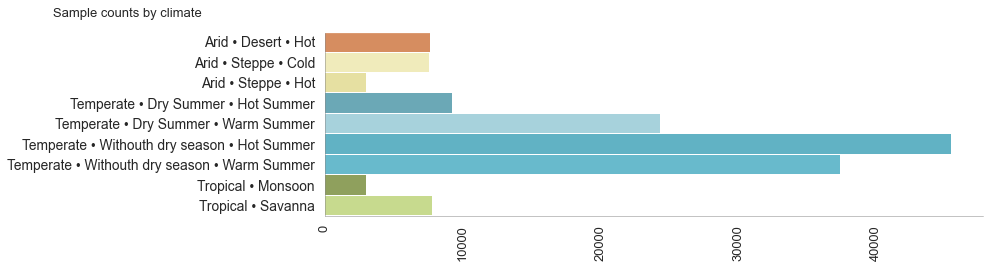

In [17]:
# Samples counts by climate

fig = plt.figure(figsize=(14, 4))

tmp = climateMerged(df).groupby(['Climate', 'Color'], as_index=False).size().sort_values('Climate')
ax = sns.barplot(tmp, y='Climate', x='size', palette=tmp.Color, errorbar=None,
                 linewidth=0, width=.95)
ax.set_title(f"Sample counts by climate", x=-.3, y=1.05, fontsize=13)
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel(None)
plt.ylabel(None)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()

del(tmp, fig, ax, edges)
plt.savefig('outpout/sample-counts-by-climate.png')

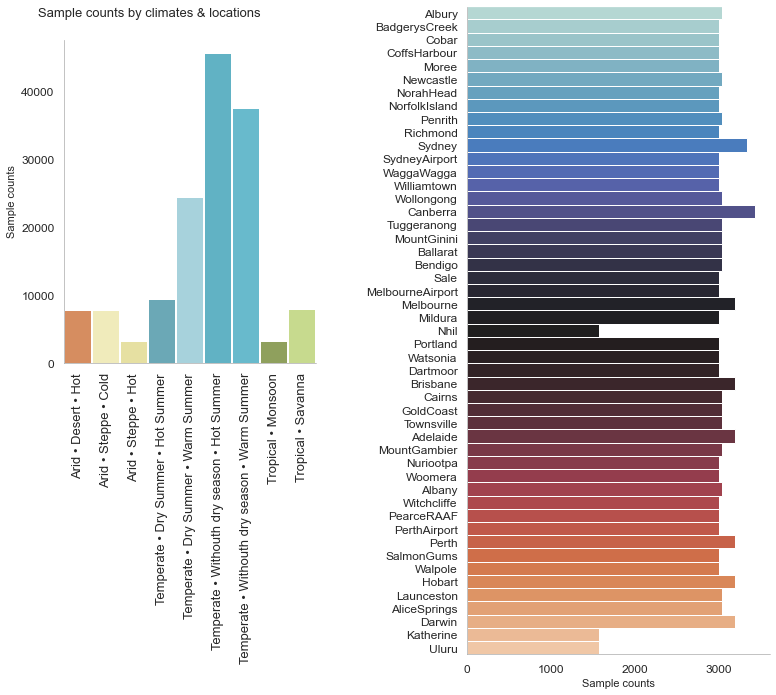

In [18]:
# Sample counts by climate and location

fig = plt.figure(figsize=(14, 9))

# By climate
ax = plt.axes([0.3,0.45,.25,.5])

tmp = climateMerged(df).groupby(['Climate', 'Color'], as_index=False).size().sort_values('Climate')
sns.barplot(tmp, x='Climate', y='size', palette=tmp.Color, errorbar=None,
            linewidth=0, width=.95)
ax.set_title(f"Sample counts by climates & locations", x=.34, y=1.05, fontsize=13)
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel(None)
plt.ylabel("Sample counts", fontsize=11)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=12)

# By location
ax = plt.axes([.7,0.0,.3,1.])
sns.countplot(df, y='Location', width=1, palette="icefire")
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel("Sample counts", fontsize=11)
plt.ylabel(None)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

del(fig, ax, tmp, edges)
plt.savefig("outpout/sample-counts-by-climate-location.png");

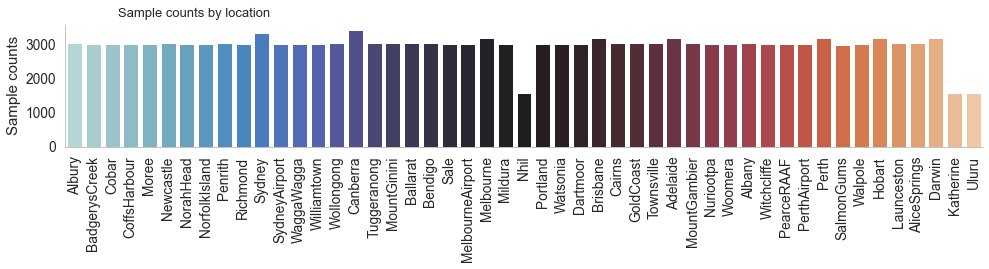

In [21]:
# Samples count's by location (keep it separated in case of)

fig = plt.figure(figsize=(14,4))

ax = sns.countplot(df, x='Location', palette="icefire")
ax.set_title(f"Sample counts by location",
            x=.14, y=1.01, fontsize=13)

ax.set_facecolor('white')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel("Sample counts")
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90)
plt.tight_layout()

del(fig, ax, edges)
plt.savefig("outpout/sample-counts-by-location.png");

### Distribution de la variable cible 

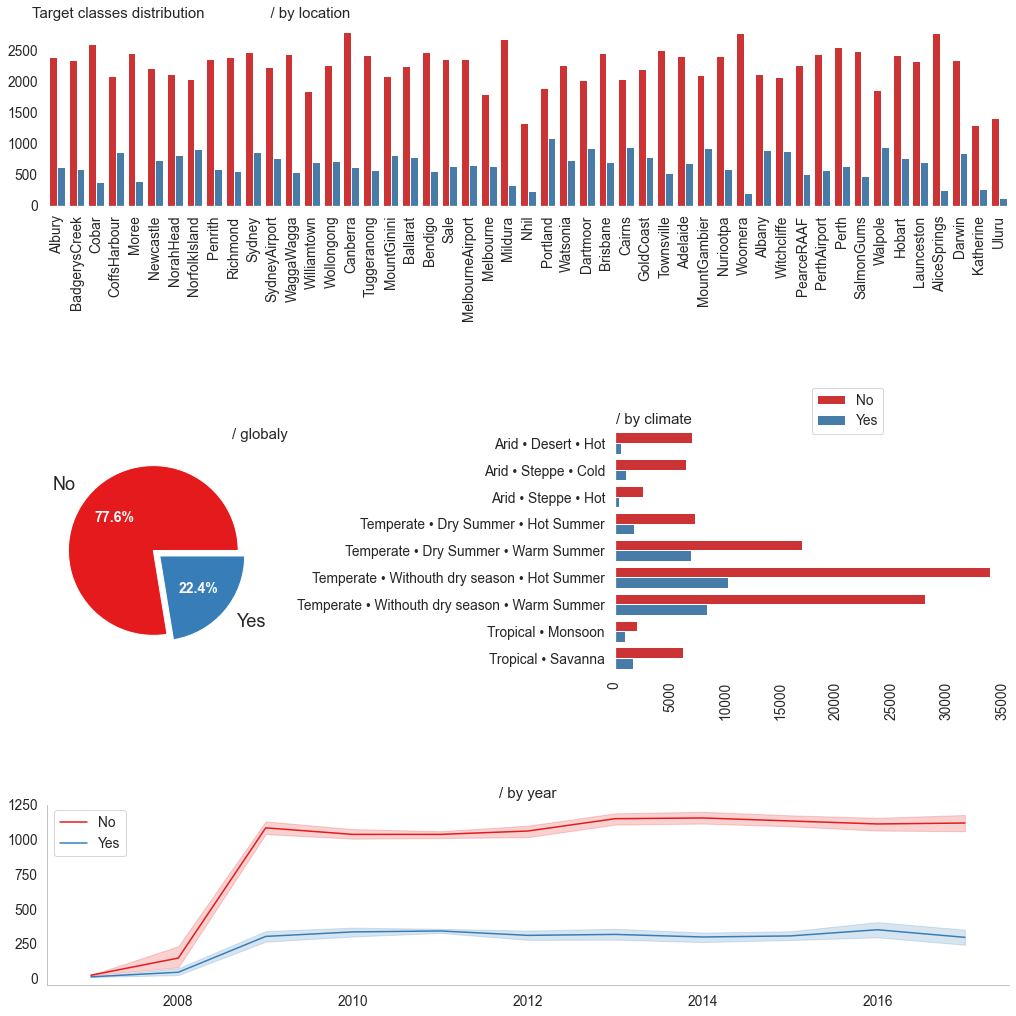

In [23]:
# RainTomorrow distribution Location/Global/Climate/Year

cmap = 'Set1'

# One Figure to rule them all
fig, axs = plt.subplot_mosaic(figsize=(14, 14), layout="constrained",
                              gridspec_kw={'width_ratios':[.7, 1.3],
                                'height_ratios':[.9, 1.2, .9], 'hspace': .2},
                              mosaic=[['head', 'head'],
                                      ['lmid', 'rmid'],
                                      ['foot', 'foot']])
for _, ax in axs.items():
    ax.set(facecolor='w')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

# By location
ax = axs.get('head')
ax = sns.countplot(df, ax=ax, x='Location', hue='RainTomorrow', palette=cmap)
ax.xaxis.set_tick_params(rotation=90) # plt.xticks(...)
ax.set_title("Target classes distribution                / by location", x=.15)
ax.legend_.set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel(None)

# Globaly (pie)
ax = axs.get('lmid')
_, txs, atxs = ax.pie( df.groupby('RainTomorrow').size(), colors=plt.colormaps[cmap].colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, explode=[0,.1],
        autopct='%.1f%%', labeldistance=1.2, textprops={'fontsize':18},
        frame=False, labels=['No', 'Yes'])
plt.setp(atxs, weight="bold", color='w', fontsize=14)
ax.set_title("/ globaly", x=1.)

# By climate
ax = axs.get('rmid')
sns.countplot(climateMerged(df).sort_values('Climate'), ax=ax, y='Climate', hue='RainTomorrow',
              hue_order=['No', 'Yes'], palette=cmap)
ax.xaxis.set_tick_params(rotation=90) # plt.xticks(...)
ax.legend(facecolor='w', loc='upper right', bbox_to_anchor=[.7, 1.2])
ax.set_title("/ by climate", x=0.1)
ax.set_xlabel(None)
ax.set_ylabel(None)

# By Years
tmp = df.groupby([df.Date.dt.to_period('M'), 'RainTomorrow'], as_index=False).size()
tmp['Month'] = tmp.Date.dt.month
tmp['Year'] = tmp.Date.dt.year

ax = axs.get('foot')
ax = sns.lineplot(tmp, ax=ax, x='Year', y='size', hue='RainTomorrow', palette=cmap)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
ax.legend(facecolor='w')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title("/ by year")

del(fig, cmap, txs, atxs, tmp, axs, ax, edges)
plt.savefig("outpout/target-distribution.png")